In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev
import sys
import os
if "../" not in sys.path:
  sys.path.append("../") 
os.chdir("..") 
from envs.data_handler import DataHandler
import envs.data_utils as du

# function for plotting
def plot_data(data_table):
    lists = data_table.groupby([data_table.columns[0], data_table.columns[1]])[data_table.columns[2]].apply(list).values
    fig = plt.figure(figsize=(50, 5))
    for l in lists:
        plt.hist(l, 50, alpha=0.5)
    plt.show()

dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
dh.data.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,49.5
1,_SExXgOcdEeet0YmmfbMwkw,CF2,16.0
2,_SEx_HucdEeet0YmmfbMwkw,CF3,31.5
3,_SEymDucdEeet0YmmfbMwkw,CF3,25.0
4,_SExYKucdEeet0YmmfbMwkw,CF3,16.0


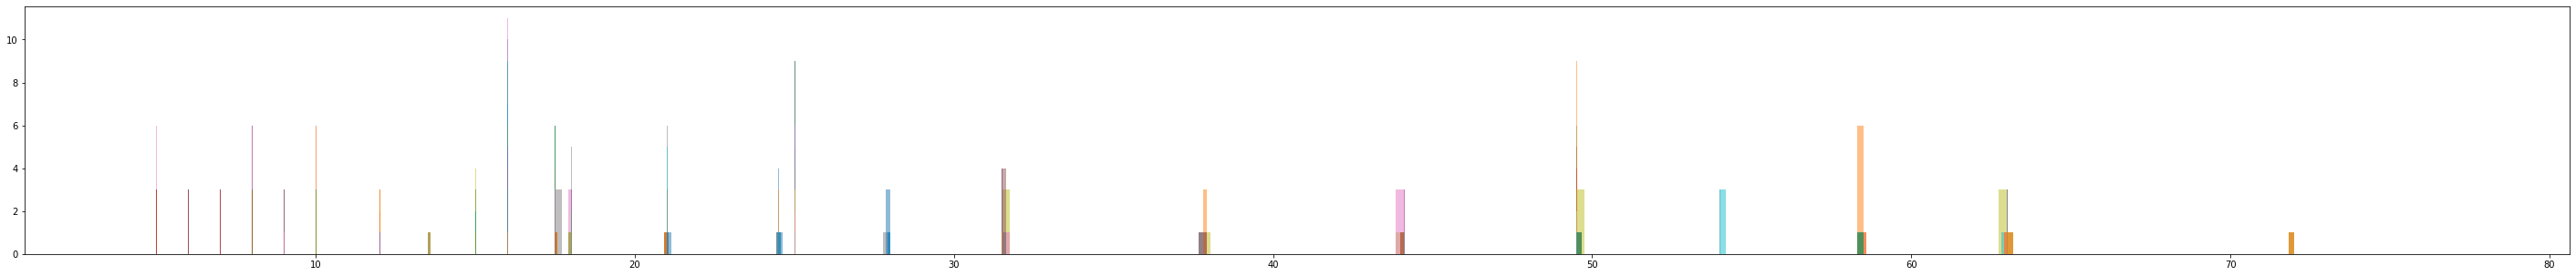

In [2]:
plot_data(dh.data)

# Data Shift

Step 1: Calculate the Standard Deviation

In [2]:
stdev_values = dh.data.groupby([dh.data.columns[0], dh.data.columns[1]]).std().reset_index().fillna(0)
stdev_values.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SE-L2-cdEeet0YmmfbMwkw,CF1,0.0
1,_SE-L4ucdEeet0YmmfbMwkw,CF1,0.0
2,_SE-L5ecdEeet0YmmfbMwkw,CF1,0.0
3,_SE-L8ecdEeet0YmmfbMwkw,CF3,0.0
4,_SE-L_ecdEeet0YmmfbMwkw,CF1,0.0


Step 2: Calculate the mean of each <component, failure> combinations and sort them ascending

In [3]:
ordering1 = du.get_ordering(dh.data)
ordering1.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
698,_SFLoA-cdEeet0YmmfbMwkw,CF2,5.0
109,_SE7IwecdEeet0YmmfbMwkw,CF1,5.0
493,_SFFhMOcdEeet0YmmfbMwkw,CF3,5.0
437,_SFE5-OcdEeet0YmmfbMwkw,CF3,5.0
661,_SFLB7-cdEeet0YmmfbMwkw,CF3,5.0


Step 3: Iterate over data and shift it

In [4]:
data_new = du.shift_data(dh.data)  
data_new.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,60.295935
1,_SExXgOcdEeet0YmmfbMwkw,CF2,16.000000
2,_SEx_HucdEeet0YmmfbMwkw,CF3,31.500000
3,_SEymDucdEeet0YmmfbMwkw,CF3,25.000000
4,_SExYKucdEeet0YmmfbMwkw,CF3,16.000000


## Step 4: Analyse

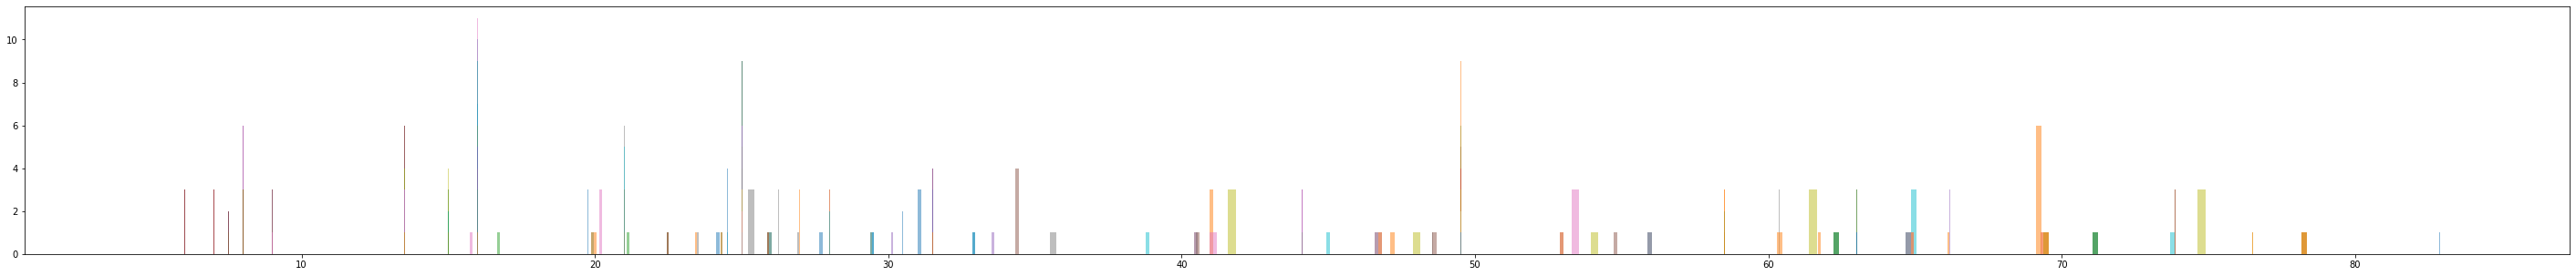

In [7]:
plot_data(data_new)

## Step 5: Perform T-Test

In [5]:
result = du.perform_ttest(data_new)
print(len(result[result['pvalue']<0.025]), 'of the ', len(result.index) ,' <component, failure> combination pairs are statistical significant')

/Users/rachel/.local/share/virtualenvs/rl-4-self-repair-tzCb2l5a/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rachel/.local/share/virtualenvs/rl-4-self-repair-tzCb2l5a/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


13 of the  914  <component, failure> combination pairs are statistical significant


# Experiment

First transform data and then shift it.

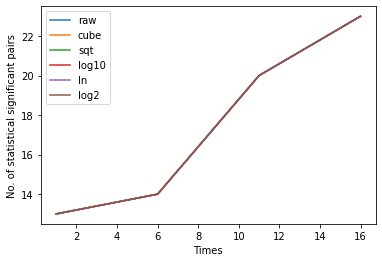

In [6]:
# <component, failure> = x + (prestd + curstd) * times
types = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']
x_ticks = range(1,20, 5)

for t in types:
    results = []
    for i in x_ticks:
        shifted_data = du.shift_data(dh.data, times=i)
        ttest = du.perform_ttest(shifted_data)
        r = len(ttest[ttest['pvalue']<0.025])
        results.append(r)
    plt.plot(x_ticks, results, label=t)

plt.xlabel("Times")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.show()

Evaluating the best number of times for shifting:

{'raw': (117, 35), 'cube': (117, 35), 'sqt': (117, 35), 'log10': (117, 35), 'ln': (117, 35), 'log2': (117, 35)}


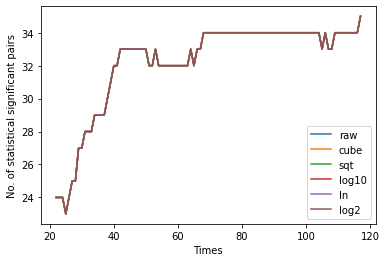

In [10]:
result = {}
times = range(22, 914, 1)

for t in types:
    x = []
    values = []
    stop = 50
    if t not in result:
        result[t] = (0,0) # (times, number of statistical significant) 
    for i in times:
        if stop != 0:
            shifted_data = du.shift_data(dh.data, times=i)
            ttest = du.perform_ttest(shifted_data)
            r = len(ttest[ttest['pvalue']<0.025])
            values.append(r)
            x.append(i)
            print(t, i, r, stop, end="\r")
            if r > result[t][1]:
                result[t] = (i, r)
                stop = 50
            else:
                stop -= 1
        else:
            break
    plt.plot(x[:len(x)-50], values[:len(values)-50], label=t)

print(result)
plt.xlabel("Times")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.savefig('data_analysis/shifting_parameter_evaluation.pdf') 
plt.show()

And then saving optimal shifted data to csv

In [11]:
result = {'raw': (117, 35), 'cube': (117, 35), 'sqt': (117, 35), 'log10': (117, 35), 'ln': (117, 35), 'log2': (117, 35)}
optimal_shifted_data = dh.data

for t, value in result.items():
    optimal_shifted_data = du.shift_data(optimal_shifted_data, times=value[0])
    
optimal_shifted_data.to_csv('data/prepared_data/LinearShifted_Id.csv')
print("Data saved.")

Data saved.
